In [1]:
import os
import json
import sys
import glob
import re
import gc

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.utilities.model_summary import ModelSummary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from data_module.data_module import ALDataModule_v1, FFTDataModule
from utils.data_utils import limit_filter_data_by_class
from utils.model_utils import reset_weight_model

from model.classifier_model import Classifier1DMaxPoolBNModel, Classifier1D
from utils.model_utils import unwrap_model

from config.optimizer_param_config import optimizer_param_dict
from config.channel_param_config import channel_param_dict



/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument('-ck', "--save_model_folder", type=str, default="20_AL_train_unbalance/4cnn_64-8-1000-4-10-300-64",
                    help=f"AL learning model")
parser.add_argument('-m', "--method", type=str, default="random",
                    help=f":: select run method from [random, sampling]")

parser.add_argument("-ss", "--sampling_size", type=int, default=100,
                    help=f"sampler size to take from additional dataset. normally < 5000, Not effective for method `full`")

parser.add_argument("-tl", "--train_limit_data", type=int, default=None,
                    help=f"Used for limit the number of data in train data, -1 mean no limit")

parser.add_argument("-cn", "--class_num", type=int, default=None,
                    help=f"Number of class num use to train")

parser.add_argument("--target_class", type=int, default=None,
                    help=f"Number of class num use to train")

parser.add_argument("--target_class_data_num", type=int, default=None,
                    help=f"Number of data for the target class to train")

parser.add_argument("--filter_unselected_data_num", type=int, default=5000,
                    help=f"Used for get the size of additional dataset")

parser.add_argument("--reset_weight", type=int, default=1,
                    help=f"Reset weight before training. If not reset, we will continue learning from the checkpoint")

parser.add_argument("-r", "--random_seed", type=int, default=64,
                    help=f"Random Seed")

parser.add_argument("--eval_mode", type=int, default=0,
                    help=f"Eval all models")

parser.add_argument("--patience", type=int, default=None,
                    help=f"Early stopping patience")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()

In [15]:
L.seed_everything(42)

Seed set to 42


42

In [16]:
# save_model_folder = os.path.basename(args.save_model_folder)
save_model_folder = os.path.basename(args.save_model_folder)
print(save_model_folder)
match = re.match(r"[a-z0-9_]+-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-\d+", save_model_folder)

args.class_num = int(match.group(1))
args.train_limit_data = int(match.group(2))
args.target_class = int(match.group(3))
args.target_class_data_num = int(match.group(4))
args.patience = int(match.group(5))


4cnn_64-8-1000-4-10-300-64


In [17]:
n_epochs = 2000000
patience = n_epochs//5000
batch_size = 512

optimizer, optimizer_param = optimizer_param_dict["Adam"]
dataset_path = f"dataset/processed_concat_data_{args.class_num}_labels"
reset_str = "_reset" if args.reset_weight else ""

log_save_dir = "lightning_logs" 
log_save_name = f"20.2_AL_train_unbalance/{save_model_folder}_{args.method}_{args.sampling_size}_{args.random_seed}_{reset_str}"

In [18]:
data_module = ALDataModule_v1(dataset_path=dataset_path, batch_size=512, prefix="torso_", postfix="_fft", sampler_size=args.sampling_size)
data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)
train_data, train_label = data_module.reduce_one_class_number(data_module.train_data, data_module.train_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)
val_data, val_label = data_module.reduce_one_class_number(data_module.val_data, data_module.val_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)
test_data, test_label = data_module.reduce_one_class_number(data_module.test_data, data_module.test_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)

data_module.set_train_val_test_pred_data(
    train_data = train_data,
    train_label = train_label,
    val_data = val_data,
    val_label = val_label,
    test_data = test_data,
    test_label = test_label,
    pred_data = test_data,
)

print(np.unique(data_module.train_label, return_counts=True))
print(np.unique(data_module.val_label, return_counts=True))
print(np.unique(data_module.test_label, return_counts=True))


limit_and_set_train_data limit_number= 1000
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
reduce_one_class_number target_class= 4 target_class_data_num= 10
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869,   10, 1000, 1000, 1000, 1000]))
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869,   10, 1000, 1000, 1000, 1000]))


In [19]:
checkpoint_path = glob.glob(os.path.join(log_save_dir, args.save_model_folder, "version_0", "checkpoints", "*.ckpt"))[0]

net = Classifier1DMaxPoolBNModel.load_from_checkpoint(checkpoint_path)

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name     | Type        | Params | In sizes     | Out sizes   
------------------------------------------------------------------------
0  | cnn      | Sequential  | 316 K  | [10, 6, 257] | [10, 256, 1]
1  | cnn.0    | Conv1d      | 1.6 K  | [10, 6, 257] | [10, 32, 84]
2  | cnn.1    | BatchNorm1d | 64     | [10, 32, 84] | [10, 32, 84]
3  | cnn.2    | ReLU        | 0      | [10, 32, 84] | [10, 32, 84]
4  | cnn.3    | Conv1d      | 18.5 K | [10, 32, 84] | [10, 64, 26]
5  | cnn.4    | BatchNorm1d | 128    | [10, 64, 26] | [10, 64, 26]
6  | cnn.5    | ReLU        | 0      | [10, 64, 26] | [10, 64, 26]
7  | cnn.6    | Conv1d      | 65.7 K | [10, 64, 26] | [10, 128, 7]
8  | cnn.7    | BatchNorm1d | 256    | [10, 128, 7] | [10, 128, 7]
9  | cnn.8    | ReLU        | 0      | [10, 128, 7] | [10, 128, 7]
10 | cnn.9    | Conv1d      | 229 K  | [10, 128, 7] | [10, 256, 1]
11 | cnn.10   | BatchNorm1d | 512    | [10, 256, 1] | [10, 256, 1]
12 | cnn.11   | ReLU        | 0      | [10, 256, 1] | [1

In [20]:
def process_tl_and_additional_ds(data_module):
    assert args.train_limit_data + args.filter_unselected_data_num < np.max(np.unique(data_module._train_label, return_counts=True)[1])
    print("data_module.choice_limited_list", data_module.choice_limited_list[:100])
    
    unselected_train_idx = list(set(range(len(data_module._train_label))) - set(data_module.choice_limited_list))
    unselected_train_data = data_module._train_data[unselected_train_idx]
    unselected_train_label = data_module._train_label[unselected_train_idx]

    filter_data, filter_label, choice_idx = limit_filter_data_by_class(unselected_train_data, unselected_train_label, args.filter_unselected_data_num)
    
    return filter_data, filter_label, choice_idx
    

In [21]:
def proceed_output_target_class(data_module, data, label, net_output):
    print("proceed_output_target_class")
    assert len(data) == len(label)
    if isinstance(net_output, list):
        output_concat = torch.concat(net_output)
    else:
        output_concat = net_output

    scores = output_concat[:, args.target_class - 1].numpy()
    ranks = np.argsort(scores)
    ranks = ranks[::-1]
    data_module.sampling_rank = ranks
    
    data_module._uncertainty_data = data[data_module.sampling_rank][:data_module.hparams.sampler_size]
    data_module._uncertainty_label = label[data_module.sampling_rank][:data_module.hparams.sampler_size]

    data_module._train_uncertainty_data = np.concatenate([data_module.train_data, data_module._uncertainty_data])
    data_module._train_uncertainty_label = np.concatenate([data_module.train_label, data_module._uncertainty_label])
    
    data_module.set_only_train_data(data_module._train_uncertainty_data, data_module._train_uncertainty_label)
    

In [22]:
assert args.method in [ "sampling",  "random",  "full"  ]

if args.method == "sampling":
    # Add to training dataset the uncertainty data for later training
    _additional_data, _additional_label, _additional_choice_idx = process_tl_and_additional_ds(data_module)
    
    data_module.set_train_val_test_pred_data(pred_data=_additional_data)
    
    trainer = L.Trainer()
    output = trainer.predict(model=net, datamodule=data_module)
    
    proceed_output_target_class(data_module, _additional_data, _additional_label, output)
    print("data_module.sampling_rank", data_module.sampling_rank[:100])

elif args.method == "random":
    _additional_data, _additional_label, _additional_choice_idx = process_tl_and_additional_ds(data_module)
    
    data_module.set_random_set(data=_additional_data, label=_additional_label)
    print("data_module.sampling_rank", data_module.random_rank)
    print(np.unique(data_module.train_label, return_counts=True))
    

data_module.choice_limited_list [18207, 21088, 13538, 24705, 34880, 21925, 14404, 9094, 32657, 30380, 12545, 24022, 24330, 34504, 34879, 35477, 62488, 39917, 22509, 18939, 31666, 47173, 48642, 59923, 6524, 25754, 62475, 25899, 6322, 25043, 6660, 57311, 54786, 13251, 53951, 8460, 42308, 38349, 4044, 8293, 22989, 22196, 42633, 23904, 27225, 41230, 8652, 50565, 39802, 49424, 23847, 32370, 34822, 55309, 10695, 60813, 18516, 52538, 57173, 7160, 44307, 20179, 3847, 23509, 39620, 55641, 49521, 43229, 12342, 31557, 26505, 2134, 30794, 32841, 61763, 14799, 9330, 46006, 17702, 31651, 50077, 26710, 5622, 23181, 8230, 53307, 40925, 34497, 17857, 4003, 30870, 35409, 4326, 55199, 10855, 5741, 8256, 50065, 51993, 22666]
limit_and_set_train_data limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
set_random_set
data_module.sampling_rank [ 5274 20930 39651 ... 20079 34789 10637]
(array([1., 2., 3., 4., 5., 6.

In [23]:
print(np.unique(data_module.train_label, return_counts=True))

(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1007, 1012, 1018,   20, 1015, 1010, 1013, 1015]))


In [88]:
## Reset net weight before training
L.seed_everything(args.random_seed)
if args.reset_weight:
    reset_weight_model(net, verbose=1)

Seed set to 42


reset <class 'torch.nn.modules.conv.Conv1d'>
reset <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
reset <class 'torch.nn.modules.conv.Conv1d'>
reset <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
reset <class 'torch.nn.modules.conv.Conv1d'>
reset <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
reset <class 'torch.nn.modules.conv.Conv1d'>
reset <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
reset <class 'torch.nn.modules.linear.Linear'>
reset <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
reset <class 'torch.nn.modules.linear.Linear'>


In [ ]:
if not args.eval_mode:
    print(" ----------------------start training---------------------------")
    from lightning.pytorch.callbacks.early_stopping import EarlyStopping
    from lightning.pytorch.callbacks import ModelCheckpoint
    from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
    
    tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
    # csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
    checkpoint_callback = ModelCheckpoint(
        dirpath=None,
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
    )
    
    trainer = L.Trainer(
        logger=[tensorboard_logger],
        callbacks=[EarlyStopping(monitor="val_loss", patience=patience), checkpoint_callback],
        max_epochs=n_epochs,
        check_val_every_n_epoch=10,
        accelerator="gpu", 
        devices=4, 
        strategy="ddp"
        )
    
    trainer.fit(model=net, datamodule=data_module)
    trainer_test_dict = trainer.logged_metrics
    
    trainer.test(model=net, datamodule=data_module)
    trainer_test_dict.update(trainer.logged_metrics)
    
    for key in trainer_test_dict.keys():
        trainer_test_dict[key] = trainer_test_dict[key].item()
    
    with open(os.path.join(trainer.logger.log_dir, "result.json"), "w") as f:
        json.dump(trainer_test_dict, f, indent=4)
    
    with open(os.path.join(trainer.logger.log_dir, "argparse_params.json"), "w") as f:
        json.dump(args.__dict__, f, indent=4)

In [24]:
# args.eval_mode = 1
if args.eval_mode:
    reset_str = ""
    lightning_save_dir = f"lightning_logs/20.2_AL_train_unbalance/"
    result_save_dict = {}

    for folder_path in glob.glob(os.path.join(lightning_save_dir, "*")):
        folder_name = os.path.basename(folder_path)
        # save_model_folder = os.path.basename(args.save_model_folder)
        
        match = re.match(r"[a-z0-9_]+-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-\d+_(\w+)_(\d+)_(\d+)_(_reset)?", folder_name)
        
        args.class_num = int(match.group(1))
        args.train_limit_data = int(match.group(2))
        args.target_class = int(match.group(3))
        args.target_class_data_num = int(match.group(4))
        args.patience = int(match.group(5))
        args.method = match.group(6)
        args.sampling_size = int(match.group(7))
        args.random_seed = int( match.group(8))
        dataset_path = f"dataset/processed_concat_data_{args.class_num}_labels"
        
        weight = glob.glob(os.path.join(folder_path, "version_0", "checkpoints", "*.ckpt"))[0]
        L.seed_everything(42)
        data_module = ALDataModule_v1(dataset_path=dataset_path, batch_size=512, prefix="torso_", postfix="_fft", sampler_size=args.sampling_size)
        data_module.set_normal_train()
        # data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)
        # train_data, train_label = data_module.reduce_one_class_number(data_module.train_data, data_module.train_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)
        # val_data, val_label = data_module.reduce_one_class_number(data_module.val_data, data_module.val_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)
        # test_data, test_label = data_module.reduce_one_class_number(data_module.test_data, data_module.test_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)
        
        # data_module.set_train_val_test_pred_data(
        #     train_data = train_data,
        #     train_label = train_label,
        #     val_data = val_data,
        #     val_label = val_label,
        #     test_data = test_data,
        #     test_label = test_label,
        #     pred_data = test_data,
        # )
        
        print(np.unique(data_module.train_label, return_counts=True))
        print(np.unique(data_module.val_label, return_counts=True))
        print(np.unique(data_module.test_label, return_counts=True))


        net = Classifier1DMaxPoolBNModel.load_from_checkpoint(weight)

        trainer = L.Trainer()
        trainer.test(model=net, datamodule=data_module, verbose=False)
        test_acc = trainer.logged_metrics["test_acc"]

        # Calculate target class accuracy
        output = trainer.predict(model=net, datamodule=data_module)
        pred = torch.argmax(torch.concat(output), dim=1)
        gt = list(map(lambda x: x[1], iter(data_module.test_dataloader())))
        gt_ravel = np.concatenate(list(map(lambda x: x.numpy(), gt)))
        target_class_idx = gt_ravel == args.target_class - 1
        
        pred_ravel = pred.numpy()
        target_class_pred_idx = pred_ravel == args.target_class - 1
        target_class_tpr = np.sum(target_class_pred_idx&target_class_idx) / np.sum(target_class_idx)
        result_save_dict[folder_name] = test_acc.item(), target_class_tpr

        gc.collect()

    print(result_save_dict)


In [88]:
dataset_path = f"dataset/processed_concat_data_{args.class_num}_labels"

log_save_dir = "lightning_logs"
log_save_name = "20_AL_train_unbalance/{}-{}-{}-{}-{}-{}-{}"



In [89]:
def create_data_module():
    L.seed_everything(42)
    print("args.target_class, args.target_class_data_num", args.target_class, args.target_class_data_num)
    data_module = ALDataModule_v1(dataset_path=dataset_path, batch_size=512, prefix="torso_", postfix="_fft")
    data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)
    train_data, train_label = data_module.reduce_one_class_number(data_module.train_data, data_module.train_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)
    val_data, val_label = data_module.reduce_one_class_number(data_module.val_data, data_module.val_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)
    test_data, test_label = data_module.reduce_one_class_number(data_module.test_data, data_module.test_label, target_class=args.target_class, target_class_data_num=args.target_class_data_num)
    
    data_module.set_train_val_test_pred_data(
        train_data = train_data,
        train_label = train_label,
        val_data = val_data,
        val_label = val_label,
        test_data = test_data,
        test_label = test_label,
        pred_data = test_data,
    )
    
    print(np.unique(data_module.train_label, return_counts=True))
    print(np.unique(data_module.val_label, return_counts=True))
    print(np.unique(data_module.test_label, return_counts=True))

    return data_module

In [90]:
def get_acc_from_save_folder(save_model_folder):
    save_model_dir = os.path.join(log_save_dir, save_model_folder)
    
    weight = glob.glob(os.path.join(save_model_dir, "version_0", "checkpoints", "*.ckpt"))[0]

    net = Classifier1DMaxPoolBNModel.load_from_checkpoint(weight)
    # data_module = create_data_module()
    data_module = ALDataModule_v1(dataset_path=dataset_path, batch_size=512, prefix="torso_", postfix="_fft")
    data_module.set_normal_train()
    
    trainer = L.Trainer()
    trainer.test(model=net, datamodule=data_module, verbose=False)
    test_acc = trainer.logged_metrics["test_acc"]

    # Calculate target class TPR
    output = trainer.predict(model=net, datamodule=data_module)
    pred = torch.argmax(torch.concat(output), dim=1)
    gt = list(map(lambda x: x[1], iter(data_module.test_dataloader())))
    
    gt_ravel = np.concatenate(list(map(lambda x: x.numpy(), gt)))
    target_class_idx = gt_ravel == args.target_class - 1
    
    pred_ravel = pred.numpy()
    target_class_pred_idx = pred_ravel == args.target_class - 1
    target_class_tpr = np.sum(target_class_pred_idx&target_class_idx) / np.sum(target_class_idx)

    print(target_class_tpr)
    print("Error number", (gt_ravel!=pred_ravel).sum())

    return test_acc, target_class_tpr

In [91]:
if args.eval_mode:
    sampling_folder_list = "20_AL_train_unbalance/4cnn_64-8-1000-3-10-300-64 20_AL_train_unbalance/4cnn_64-8-1000-3-20-300-42 20_AL_train_unbalance/4cnn_64-8-1000-3-30-400-64 20_AL_train_unbalance/4cnn_64-8-1000-3-50-200-64 20_AL_train_unbalance/4cnn_64-8-1000-3-100-400-42 20_AL_train_unbalance/4cnn_64-8-1000-4-10-400-64 20_AL_train_unbalance/4cnn_64-8-1000-4-20-300-64 20_AL_train_unbalance/4cnn_64-8-1000-4-30-200-64 20_AL_train_unbalance/4cnn_64-8-1000-4-50-400-42 20_AL_train_unbalance/4cnn_64-8-1000-4-100-300-64 20_AL_train_unbalance/4cnn_64-8-1000-5-10-400-64 20_AL_train_unbalance/4cnn_64-8-1000-5-20-200-42 20_AL_train_unbalance/4cnn_64-8-1000-5-30-300-64 20_AL_train_unbalance/4cnn_64-8-1000-5-50-400-42 20_AL_train_unbalance/4cnn_64-8-1000-5-100-300-64".split(" ")
    args.model_name = "4cnn_64"
    
    for args.target_class in [3, 4, 5]:
        for args.target_class_data_num in "10 20 30 50 100".split(" "):
            args.target_class_data_num = int(args.target_class_data_num)
            for args.random_seed in "42 64".split(" "):
                for args.patience in "200 300 400".split(" "):
                    save_model_folder = log_save_name.format(args.model_name, args.class_num, args.train_limit_data, args.target_class, args.target_class_data_num, args.patience, args.random_seed)
    
                    if save_model_folder in sampling_folder_list:
                        test_acc, target_class_tpr = get_acc_from_save_folder(save_model_folder)
                        print("test_acc, target_class_tpr", test_acc, target_class_tpr)

                        all_keys = list(result_save_dict.keys())
                        for key in all_keys:
                            if key.startswith(os.path.basename(save_model_folder)):
                                # result_save_dict[folder_name] = test_acc.item(), target_class_tpr
                                match = re.match(r"(^[a-z0-9_]+-\d+-\d+-\d+-\d+-\d+-\d+_\w+_)\d+(_\d+_(_reset)?$)", key)
                                key_0number = match.group(1) + "0" + match.group(2)
                                result_save_dict[key_0number] = test_acc.item(), target_class_tpr
    

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 150.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 174.88it/s]
0.8768699654775605
Error number 1588
test_acc, target_class_tpr tensor(0.7982) 0.8768699654775605


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 110.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 168.20it/s]
0.9010356731875719
Error number 1661
test_acc, target_class_tpr tensor(0.7889) 0.9010356731875719


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 116.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 182.80it/s]
0.9482163406214039
Error number 1787
test_acc, target_class_tpr tensor(0.7729) 0.9482163406214039


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 114.31it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 136.36it/s]
0.9746835443037974
Error number 1476
test_acc, target_class_tpr tensor(0.8124) 0.9746835443037974


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 153.56it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 135.28it/s]
0.9643268124280783
Error number 1423
test_acc, target_class_tpr tensor(0.8192) 0.9643268124280783


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 115.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 169.10it/s]
0.0
Error number 2640
test_acc, target_class_tpr tensor(0.6645) 0.0


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 148.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 140.07it/s]
0.176
Error number 2185
test_acc, target_class_tpr tensor(0.7223) 0.176


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 148.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 185.09it/s]
0.002
Error number 2461
test_acc, target_class_tpr tensor(0.6873) 0.002


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 144.92it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 182.89it/s]
0.639
Error number 1841
test_acc, target_class_tpr tensor(0.7660) 0.639


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 111.04it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 191.70it/s]
0.625
Error number 1793
test_acc, target_class_tpr tensor(0.7721) 0.625


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 150.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 182.30it/s]
0.0
Error number 2241
test_acc, target_class_tpr tensor(0.7152) 0.0


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 123.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 170.86it/s]
0.0
Error number 2419
test_acc, target_class_tpr tensor(0.6926) 0.0


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 117.94it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 140.43it/s]
0.053
Error number 2146
test_acc, target_class_tpr tensor(0.7273) 0.053


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 107.68it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 166.46it/s]
0.018
Error number 2326
test_acc, target_class_tpr tensor(0.7044) 0.018


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 149.97it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 166.58it/s]
0.281
Error number 1974
test_acc, target_class_tpr tensor(0.7491) 0.281


In [92]:
if args.eval_mode:
    result_save_dict_f = result_save_dict
    with open(f"0217_{reset_str}_result.json", "w") as f:
        json.dump(result_save_dict_f, f, indent=4)

In [93]:
for key in result_save_dict_f.keys():
    x = "4cnn_64-8-1000-3-50-200-64_random"
    if key.startswith(x): print(key)

print(len(result_save_dict_f))

4cnn_64-8-1000-3-50-200-64_random_10_64__reset
4cnn_64-8-1000-3-50-200-64_random_10_64_
4cnn_64-8-1000-3-50-200-64_random_20_64__reset
4cnn_64-8-1000-3-50-200-64_random_20_64_
4cnn_64-8-1000-3-50-200-64_random_30_64__reset
4cnn_64-8-1000-3-50-200-64_random_30_64_
4cnn_64-8-1000-3-50-200-64_random_50_64__reset
4cnn_64-8-1000-3-50-200-64_random_50_64_
4cnn_64-8-1000-3-50-200-64_random_100_64__reset
4cnn_64-8-1000-3-50-200-64_random_100_64_
4cnn_64-8-1000-3-50-200-64_random_0_64__reset
4cnn_64-8-1000-3-50-200-64_random_0_64_
360


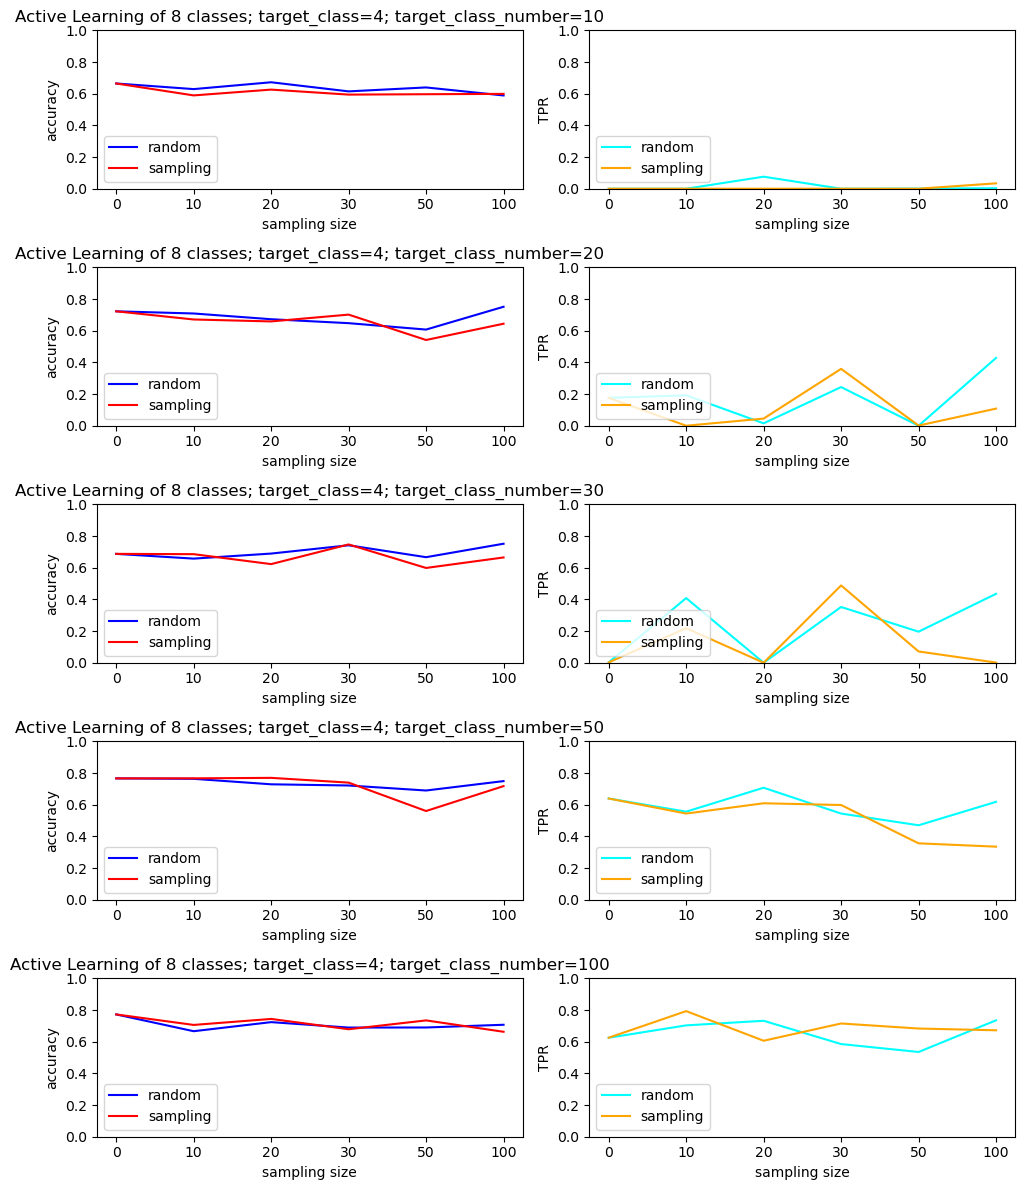

In [97]:
if args.eval_mode:
    fig, axs = plt.subplots(5, 2, figsize=(10, 12))
    
    color1_list = ["blue", "red",]
    color2_list = ["cyan", "orange",]
    
    args.class_num = 8
    args.train_limit_data = 1000
    args.target_class = 4
    args.target_class_data_num = 100
    args.patience = "*"
    args.random_seed = 64
    reset_str = "_reset"

    # fig.suptitle(f'Active Learning of {args.class_num} classes; target_class={args.target_class}; target_class_number={args.target_class_data_num}')
    
    for ax_r_idx, args.target_class_data_num in enumerate("10 20 30 50 100".split(" "), 0):
        args.target_class_data_num = int(args.target_class_data_num)
            
        for color1, color2, args.method in zip(color1_list, color2_list, ["random", "sampling"]):
            sampling_size_list = "0 10 20 30 50 100".split(" ")
            test_acc = []
            target_class_tpr = []
            
            for args.random_seed in "64".split(" "):
                for args.sampling_size in sampling_size_list:
    
                    save_model_folder_ptn = f".*-{args.class_num}-{args.train_limit_data}-{args.target_class}-{args.target_class_data_num}-\d+-\d+_{args.method}_{args.sampling_size}_{args.random_seed}_{reset_str}$"
                    for key in result_save_dict_f:
                        
                        if re.match(save_model_folder_ptn, key):
                            val = result_save_dict_f[key]
                            test_acc.append(val[0])
                            target_class_tpr.append(val[1])

            ax1, ax2 = axs[ax_r_idx, 0], axs[ax_r_idx, 1]
            ax1.plot(sampling_size_list, test_acc, label=f"{args.method}", color=color1)
            ax2.plot(sampling_size_list, target_class_tpr, label=f"{args.method}", color=color2)
            
            ax1.set_ylim(0, 1)
            ax2.set_ylim(0, 1)
                
            ax1.legend(loc='lower left')
            ax2.legend(loc='lower left')
            
            # plt.xticks(sampling_size_list)
            
            ax1.set_xlabel("sampling size")
            ax2.set_xlabel("sampling size")
            
            ax1.set_ylabel("accuracy")
            ax2.set_ylabel("TPR")

            ax1.set_title(f'Active Learning of {args.class_num} classes; target_class={args.target_class}; target_class_number={args.target_class_data_num}')

    plt.tight_layout()
